In [1]:
import tensorflow as tf
import numpy as np
print("TensorFlow version:", tf.__version__)

import h5py
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.python.keras import backend 


TensorFlow version: 2.0.0


In [2]:
f = h5py.File('../top_dataset.h5', 'r')
for key in f.keys():
    print(key)
targets = f['targets']
iters=f['iters']

#data = group['targets'][()]

iters
targets


In [3]:
X_np=np.float32(iters)
y_np=np.float32(targets)




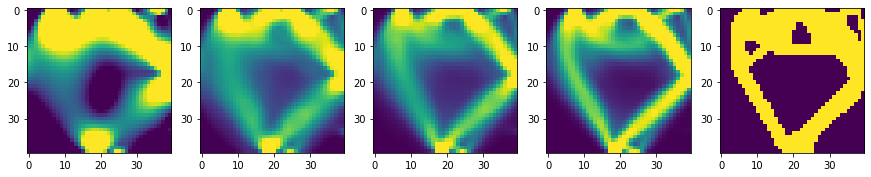

In [4]:
imN=37

f, axarr = plt.subplots(1,5)
f.set_figheight(15)
f.set_figwidth(15)

axarr[0].imshow(X_np[imN,:,:,0])
axarr[1].imshow(X_np[imN,:,:,1])
axarr[2].imshow(X_np[imN,:,:,2])
axarr[3].imshow(X_np[imN,:,:,3])
axarr[4].imshow(y_np[imN])

In [5]:
send_iter=5
X_np_5=X_np[:,:,:,send_iter-1:send_iter+1]
X_np_5[:,:,:,1]=X_np[:,:,:,send_iter-1]-X_np[:,:,:,send_iter-2]

In [6]:
from u_net import Unet_Model
model = Unet_Model()


2022-03-02 07:35:20.630955: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-03-02 07:35:21.881796: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla K20m major: 3 minor: 5 memoryClockRate(GHz): 0.7055
pciBusID: 0000:03:00.0
2022-03-02 07:35:21.889242: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-03-02 07:35:22.068132: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-03-02 07:35:22.360206: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-03-02 07:35:22.953757: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2022-03-02 07:35:23.304128: I tensorflow/stream_executor/platform/defau

In [12]:
model.train(X_np_5, y_np,EPOCHS=30)

Epoch 1, Loss: 0.02, MSE: 3.68, Accuracy IoU: 90.26, Test Loss: 0.02, Test MSE: 5.00Test IoU Accuracy: 90.48
Epoch 2, Loss: 0.02, MSE: 3.64, Accuracy IoU: 90.38, Test Loss: 0.02, Test MSE: 4.92Test IoU Accuracy: 90.62
Epoch 3, Loss: 0.02, MSE: 3.60, Accuracy IoU: 90.48, Test Loss: 0.02, Test MSE: 4.82Test IoU Accuracy: 90.80
Epoch 4, Loss: 0.02, MSE: 3.56, Accuracy IoU: 90.59, Test Loss: 0.02, Test MSE: 4.74Test IoU Accuracy: 90.94
Epoch 5, Loss: 0.02, MSE: 3.53, Accuracy IoU: 90.68, Test Loss: 0.02, Test MSE: 4.77Test IoU Accuracy: 90.89
Epoch 6, Loss: 0.02, MSE: 3.49, Accuracy IoU: 90.79, Test Loss: 0.02, Test MSE: 4.62Test IoU Accuracy: 91.16
Epoch 7, Loss: 0.02, MSE: 3.45, Accuracy IoU: 90.88, Test Loss: 0.02, Test MSE: 4.56Test IoU Accuracy: 91.28
Epoch 8, Loss: 0.02, MSE: 3.43, Accuracy IoU: 90.96, Test Loss: 0.02, Test MSE: 4.52Test IoU Accuracy: 91.34
Epoch 9, Loss: 0.02, MSE: 3.39, Accuracy IoU: 91.06, Test Loss: 0.02, Test MSE: 4.42Test IoU Accuracy: 91.54
Epoch 10, Loss: 0.0

In [8]:
#train_ds = tf.data.Dataset.from_tensor_slices((X_np_5, y_np)).shuffle(10000).batch(32)

In [9]:
#from u_net import Unet_Model
#model = Unet_Model()

In [10]:
'''
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")
'''
print()

In [4]:
#x_train.shape

In [ ]:

f, axarr = plt.subplots(1,2)
f.set_figheight(5)
f.set_figwidth(5)

axarr[0].imshow(X_np_5[imN,:,:,0])
axarr[1].imshow(X_np_5[imN,:,:,1])


In [ ]:
n=5
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_np_5, y_np)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((X_np_5, y_np)).batch(32)

In [ ]:
'''
class Unet_Model(Model):
    def __init__(self):
        super(Unet_Model, self).__init__()
        self.conv1_1 = Conv2D(16, (3,3), padding='same', activation='relu')
        self.conv1_2 = Conv2D(16, (3,3), padding='same', activation='relu')
        #### Level 2
        self.pool2_1 = MaxPool2D((2, 2), padding='same') 
        self.conv2_1 = Conv2D(32, (3, 3), padding='same', activation='relu')
        self.drop2_1 = Dropout(0.1)
        self.conv2_2 = Conv2D(32, (3, 3), padding='same', activation='relu')

        ######### Level 3
        self.pool3_1 = MaxPool2D((2, 2), padding='same')
        self.conv3_1 = Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv3_2 = Conv2D(64, (3, 3), padding='same', activation='relu')

        self.conv3_3 = Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv3_4 = Conv2D(64, (3, 3), padding='same', activation='relu')
        self.up3_1 = UpSampling2D()

        #### Level 2
        self.conv2_3 = Conv2D(32, (3, 3), padding='same', activation='relu')
        self.drop2_2 = Dropout(0.1)
        self.conv2_4 = Conv2D(32, (3, 3), padding='same', activation='relu')
        self.up2_1 = UpSampling2D()

        # Level 1
        self.conv1_3 = Conv2D(16, (3, 3), padding='same', activation='relu')
        self.conv1_4 = Conv2D(16, (3, 3), padding='same', activation='relu')
        self.out = Conv2D(1, (3, 3), padding='same', activation='sigmoid')


    def call(self, x):
        print(x.shape)
        x = self.conv1_1(x)
        conv1_2 = self.conv1_2(x)

        x = self.pool2_1(conv1_2)
        x = self.conv2_1(x)
        x = self.drop2_1(x)
        x_conv2_2 = self.conv2_2(x)

        x = self.pool3_1(x_conv2_2)
        x = self.conv3_1(x)
        x = self.conv3_2(x)

        x = self.conv3_3(x)
        x = self.conv3_4(x)
        x = self.up3_1(x)

        x = Concatenate(axis=3)([x_conv2_2, x])
        x = self.conv2_3(x)
        x = self.drop2_2(x)
        x = self.conv2_4(x)
        x = self.up2_1(x)
        x = Concatenate(axis=3)([conv1_2, x])
        x = self.conv1_3(x)
        x = self.conv1_4(x)
        x = self.out(x)
        return x
'''
# Create an instance of the model
print()

In [ ]:
#conf_loss = tf.losses.LogCosh(output_true, output_pred, reduction=tf.losses.Reduction.MEAN)
#vol_loss = tf.square(tf.reduce_mean(output_true - output_pred))
#loss = conf_loss + vol_coeff * vol_loss


#loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) #log loss ele necese
loss_object = tf.keras.losses.LogCosh()
optimizer = tf.keras.optimizers.Adam()


Epoch 1, Loss: 0.03, MSE: 5.64, Accuracy IoU: 85.95, Test Loss: 0.03, Test MSE: 5.94Test IoU Accuracy: 88.78
Epoch 2, Loss: 0.02, MSE: 4.22, Accuracy IoU: 88.89, Test Loss: 0.02, Test MSE: 5.67Test IoU Accuracy: 89.26
Epoch 3, Loss: 0.02, MSE: 4.09, Accuracy IoU: 89.22, Test Loss: 0.02, Test MSE: 5.52Test IoU Accuracy: 89.54
Epoch 4, Loss: 0.02, MSE: 4.00, Accuracy IoU: 89.45, Test Loss: 0.02, Test MSE: 5.39Test IoU Accuracy: 89.77
Epoch 5, Loss: 0.02, MSE: 3.93, Accuracy IoU: 89.62, Test Loss: 0.02, Test MSE: 5.30Test IoU Accuracy: 89.92
Epoch 6, Loss: 0.02, MSE: 3.88, Accuracy IoU: 89.75, Test Loss: 0.02, Test MSE: 5.22Test IoU Accuracy: 90.08
Epoch 7, Loss: 0.02, MSE: 3.82, Accuracy IoU: 89.91, Test Loss: 0.02, Test MSE: 5.14Test IoU Accuracy: 90.23
Epoch 8, Loss: 0.02, MSE: 3.77, Accuracy IoU: 90.04, Test Loss: 0.02, Test MSE: 5.11Test IoU Accuracy: 90.28
Epoch 9, Loss: 0.02, MSE: 3.72, Accuracy IoU: 90.18, Test Loss: 0.02, Test MSE: 5.04Test IoU Accuracy: 90.40
Epoch 10, Loss: 0.0

16

In [ ]:
train_ds

In [ ]:
tst=model(images,training=False)
print(f'MSE: {test_accuracy(labels, tst):.2f}, ')
print(f'IOU: {test_IoU_accuracy(labels, tst) :.2f}, ')

tst=tst.numpy()
tst=np.round(tst)
print(tst.shape)

In [ ]:
for i in range(3):
    f, axarr = plt.subplots(1,4)
    f.set_figheight(15)
    f.set_figwidth(15)

    axarr[0].imshow(images[i,:,:,0])
    axarr[1].imshow(images[i,:,:,1])
    axarr[2].imshow(tst[i,:,:,0])
    axarr[3].imshow(labels[i])


In [19]:
#tst[0,:,:,]